<a href="https://colab.research.google.com/github/SLVmain/Deep_Learning_practice/blob/main/HW_22_Reinforced_Q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом задании, вам необходимо воспроизвести программу, которая обучает Q-таблицу для нахождения кратчайщего пути. Рутинный код, который отображает графики, можно скопировать с лекционного ноутбука - но весь остальной код рекомендуется писать самому.

Далее, нужно провести несколько простых экспериментов с параметрами `epsilon` и `kf_rewards`.

1. `epsilon = 1` и `kf_rewards = 0.99`

2. `epsilon = 1` и `kf_rewards = 1`

3. `epsilon = 0` и `kf_rewards = 0.99`

4.  `epsilon = 1` и `kf_rewards = 0`

Помните, что значение `epsilon` будет постепенно падать в ходе обучения алгоритма.

После того, как вы проведёте все 4 эксперимента, напишите свои выводы: как агент обучается при каждом наборе параметров.

In [ ]:
#Импорт библиотек
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from IPython.display import clear_output
import time
sns.set_style('darkgrid')

In [ ]:
# Функция создания игрового поля

def createField(): 
  
  # Создаем полотно:
  fig, ax = plt.subplots(1, figsize=(24, 10)) 

  # Создаем прямоугольник вокруг всего игрового поля:
  rect = patches.Rectangle((0, 5), 12, -5, linewidth = 2, edgecolor = 'black') 
    
  # Рисуем прямоугольник:
  ax.add_patch(rect) 

  # Создаем прямоугольник стартовой позиции:
  rect = patches.Rectangle((1,1), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'white', alpha = 0.3) 
  
  # Рисуем прямоугольник:
  ax.add_patch(rect)         
  
  # Рисуем «опасные» прямоугольники по границе игрового поля:

  for i in range(2,10):
    rect = patches.Rectangle((i,1), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'red', alpha = 0.5)
    ax.add_patch(rect)
  
  for i in range(1,12):
    rect = patches.Rectangle((i,5), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'red', alpha = 0.5)
    ax.add_patch(rect)
  
  for i in range(1, 6):
    rect = patches.Rectangle((0,i), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'red', alpha = 0.5)
    ax.add_patch(rect)
  
  for i in range(1, 5):
    rect = patches.Rectangle((11,i), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'red', alpha = 0.5)
    ax.add_patch(rect)        
  
  
  # Создаем прямоугольник финишной позиции:
  rect = patches.Rectangle((10,1), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'green', alpha = 0.4) 
  
  # Рисуем прямоугольник:
  ax.add_patch(rect) 
  
  plt.xticks(np.arange(13))
  plt.yticks(np.arange(6))
  
  return fig,ax

In [ ]:
points = [-50, -1, 10] #награда

step = ([[-1,0], [0,1], [1,0],[0,-1]])

kf_rewards_list = [0.99, 1, 0.99, 0]
kf_rewards = kf_rewards_list[0]  

epsilon_list = [1, 1, 0, 1]
epsilon = epsilon_list[0]

# Матрица наград игрового поля (Q-таблица): 
rewards = np.zeros((5,13,4)) # 4 - это варианты шага step

start_position = np.array([1,0])

finish_position = np.array([10,0])


# Начальные награды в стартовой точке (инициализируем как -40, чтобы ускорить обучение):
rewards[start_position[1], start_position[0]] = points[0]+10

In [ ]:
# Функция получения случайного хода

 
def GetNextRandomPosition(current_position, positions):
  while True:      
    
    idx = np.random.randint(4)  #выбор шага, у нас 4 варианта
    next_position = current_position + step[idx]
    # Если награда за движение в указанную точку не равна минимальное (означает, что двигаемся в «опасную» точку):
    if rewards[current_position[1], current_position[0], idx] != points[0]:
      if next_position.min() >=0 and next_position[1] <5 and next_position[0] <12: # проверка чтобы не выйти за границы игрового поля

        if len(positions)>1: # Если это не первый шаг:
  
          if list(next_position) != positions[-2]:   ## Если не делаем шаг назад:                         
            return next_position
        else:
          return next_position

In [ ]:
# Функция: сыграть одну партию

def playGame(num):
  global epsilon
  
  # Очищаем экран:
  clear_output(wait = True)  

  # Текущая позиция равна стартовой: 
  current_position = start_position 

  # В список позиций записываем стартовую позицию:
  positions = [list(start_position)] 

  while True: 

    # Создаем игровое поле:
    f,a = createField() 

    # Генерируем случайное значение от 0 до 1. И, если оно меньше текущего значения epsilon:
    if np.random.random() < epsilon:
      
      # Делаем случайный шаг:
      next_position = GetNextRandomPosition(current_position, positions)
    
    # В противном случае:
    else:                
      re = np.argmax(rewards[current_position[1], current_position[0]]) # Получаем максимальное вознаграждение из текущей позиции
      next_position = current_position + step[re] # Делаем шаг по пути максимального вознаграждения
      
      # Если вышли за пределы игрового поля:
      if next_position.min() < 0 or next_position[1] > 4 or next_position[0] > 11:
        
        # то перезаписываем новое положение на случайное:
        next_position = GetNextRandomPosition(current_position, positions)                    
                
      # Если это не первый шаг        
      if len(positions) > 1:
        
        # Если сделали шаг назад:        
        if list(next_position) == positions[-2]:
            
          # Перезаписываем новое положение на случайное:
          next_position = GetNextRandomPosition(current_position, positions)
    
    # Если epsilon больше 0.01:
    if epsilon > 0.01:
      epsilon *= 0.999 # Изменяем значение (экспоненциальный спад epsilon)  

    # Добавляем в список позиций новое положение агента:
    positions.append(list(next_position)) 
    
    # Визуализируем путь игрока желтыми линиями:
    for p in range(len(positions)-2):
      x = [positions[p][0] + 0.5, positions[p+1][0] + 0.5]
      y = [positions[p][1] + 0.5, positions[p+1][1] + 0.5]
      a.plot(x, y, marker = 'o', color = 'y', linewidth = 4)            
    
    # Последний шаг рисуем зеленой линией:
    x = [positions[-2][0] + 0.5, positions[-1][0] + 0.5]
    y = [positions[-2][1] + 0.5, positions[-1][1] + 0.5]
    a.plot(x, y, marker = 'o', color = 'g', linewidth = 4)
            
    # Печатаем текстовую информацию (награды в каждой ячейке игрового поля):
    for i in range(5):
      for j in range(12):
        txt = 'Left:' + str(round(rewards[i,j,0], 2)) + '\n' +\
          'Up:' + str(round(rewards[i,j,1], 2)) + '\n' +\
          'Right:' + str(round(rewards[i,j,2], 2)) + '\n' +\
          'Down:' + str(round(rewards[i,j,3], 2))                
        a.text(j + 0.1, i + 0.2, txt, fontsize = 16, alpha = 0.7) 
    plt.title(f"Игра № {num + 1}:", fontsize = 16)
    plt.show()
    
    # Перезаписываем текущее положение:        
    current_position = next_position 

    # Очищаем экран:
    clear_output(wait = True) 
            
    # Если попали в «опасную» точку или дошли до финиша:
    if next_position[1] == 0 or next_position[1] == 4 or next_position[0] == 0 or next_position[0] == 11:
      break # Выходим из цикла 
      
  return positions # Возвращаем список позиций

In [ ]:
def train(count = 20, auto = True):

  global rewards

  # В каждой партии:
  for num in range(count): 
    
    # Играем партию и записываем позиции, чтобы посчитать награды:
    positions = playGame(num) 

    # Создаем игровое поле:
    f,a = createField() 

    # Рисуем пройденный путь агента:          
    for p in range(len(positions) - 1): 
      x = [positions[p][0] + 0.5, positions[p+1][0] + 0.5]
      y = [positions[p][1] + 0.5, positions[p+1][1] + 0.5]
      a.plot(x, y, marker = 'o', color = 'y', linewidth=4)
              
      action = step.index(list(np.array(positions[-1]) - np.array(positions[-2])))
      
      rew = points[0] # Извлекаем награды за действие
      
      if positions[-1] == list(finish_position): # Если достигли финишной клетки
        rew = points[2] # Награждаем 10 очками
      rewards[positions[-2][1],positions[-2][0]][action] = rew #Обновляем матрицу наград
      
      y = 1
      
      if len(positions)>2: # Если совершили больше чем 2 шага
        for i in range(len(positions)-3, -1, -1): #Считаем награды для всех клеток, начиная с последней
          action = step.index(list(np.array(positions[i+1]) - np.array(positions[i])))
          rewards[positions[i][1],positions[i][0]][action] = points[1] + y * max(rewards[positions[i+1][1],positions[i+1][0]]) # Штрафуем за 1 очко на наждый шаг, прибавляем награжу за следующий шаг
          y *= kf_rewards # Скалируем награды в соответствии kf_rewards
      
      for i in range(5):
        for j in range(12): # Записываем вычисленную Q-таблицу
          txt = 'Left:'+str(round(rewards[i,j,0],2))+'\n'+\
            'Up:'+str(round(rewards[i,j,1],2))+'\n'+\
            'Right:'+str(round(rewards[i,j,2],2))+'\n'+\
            'Down:'+str(round(rewards[i,j,3],2))                
          a.text(j+0.1, i+0.2, txt, fontsize=16, alpha = 0.7)      
      
      plt.show()
      
      clear_output(wait=True) # Очищаем экран

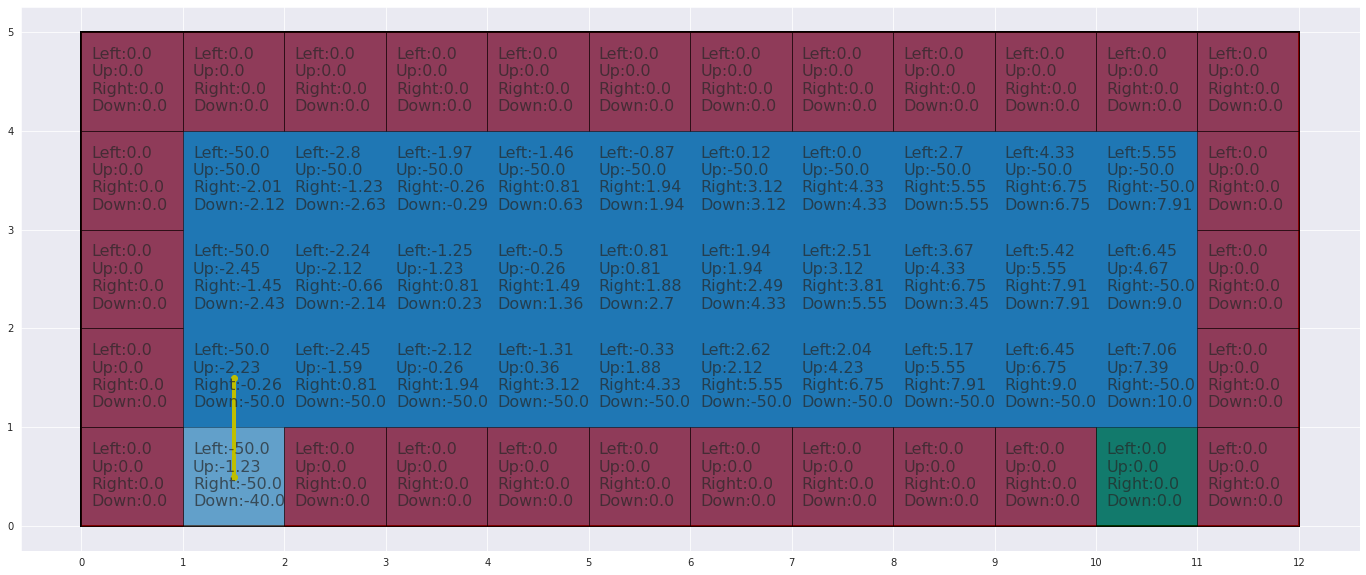

In [ ]:
kf_rewards_list = [0.99, 1, 0.99, 0]
kf_rewards = kf_rewards_list[0]  

epsilon_list = [1, 1, 0, 1]
epsilon = epsilon_list[0]

# Обучаем агента на 200 играх, смотрим, как он обучается:
position = train(200)

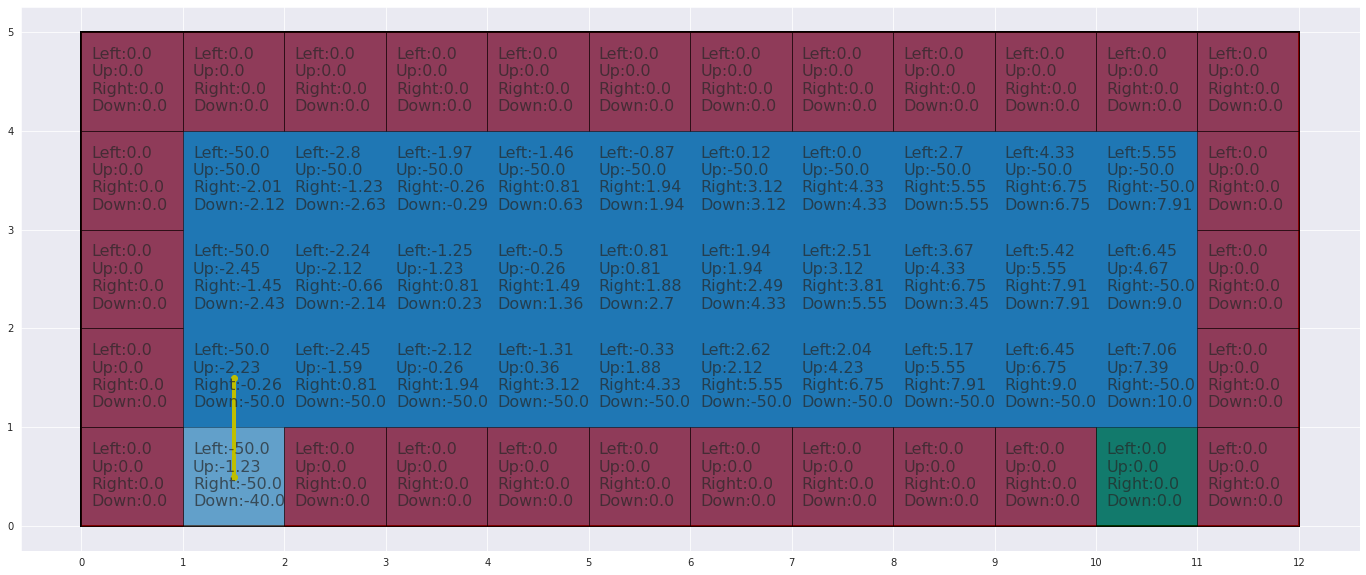

In [ ]:
# Тестируем результат (ставим нулевое значение параметру epsilon):
epsilon = 0
position = train(1)

агент обучился

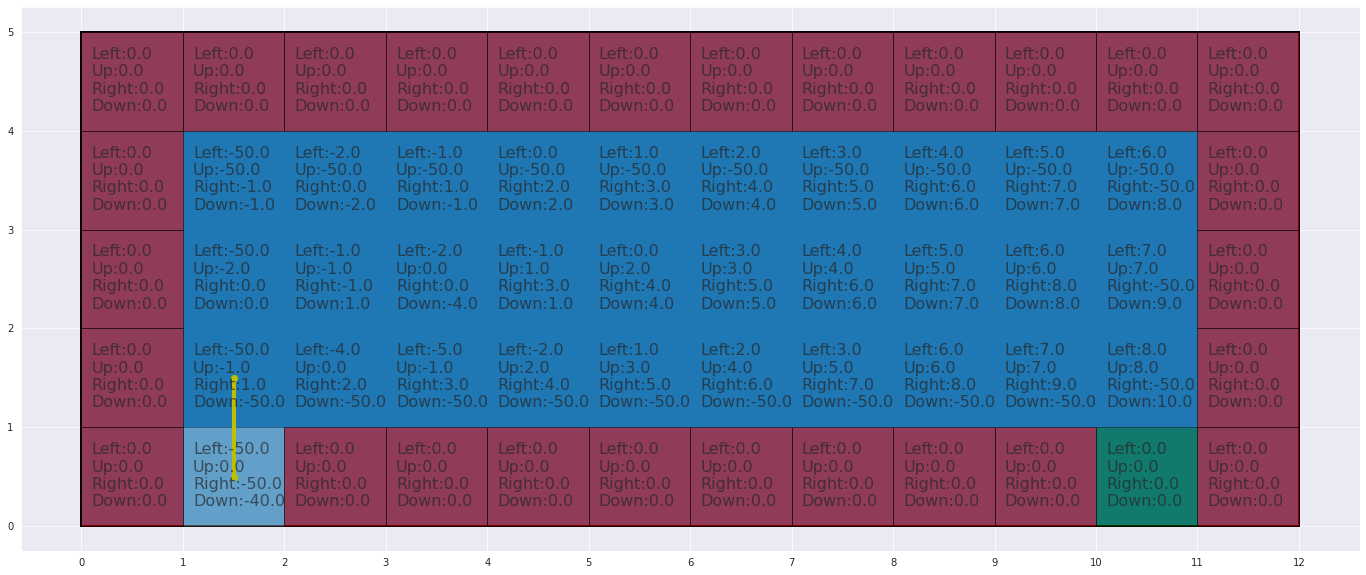

In [ ]:
points = [-50, -1, 10] #награда

step = ([[-1,0], [0,1], [1,0],[0,-1]])

# Матрица наград игрового поля (Q-таблица): 
rewards = np.zeros((5,13,4)) # 4 - это варианты шага step

start_position = np.array([1,0])

finish_position = np.array([10,0])


# Начальные награды в стартовой точке (инициализируем как -40, чтобы ускорить обучение):
rewards[start_position[1], start_position[0]] = points[0]+10

kf_rewards_list = [0.99, 1, 0.99, 0]
kf_rewards = kf_rewards_list[1]  

epsilon_list = [1, 1, 0, 1]
epsilon = epsilon_list[1]

# Обучаем агента на 200 играх, смотрим, как он обучается:
position1 = train(200)

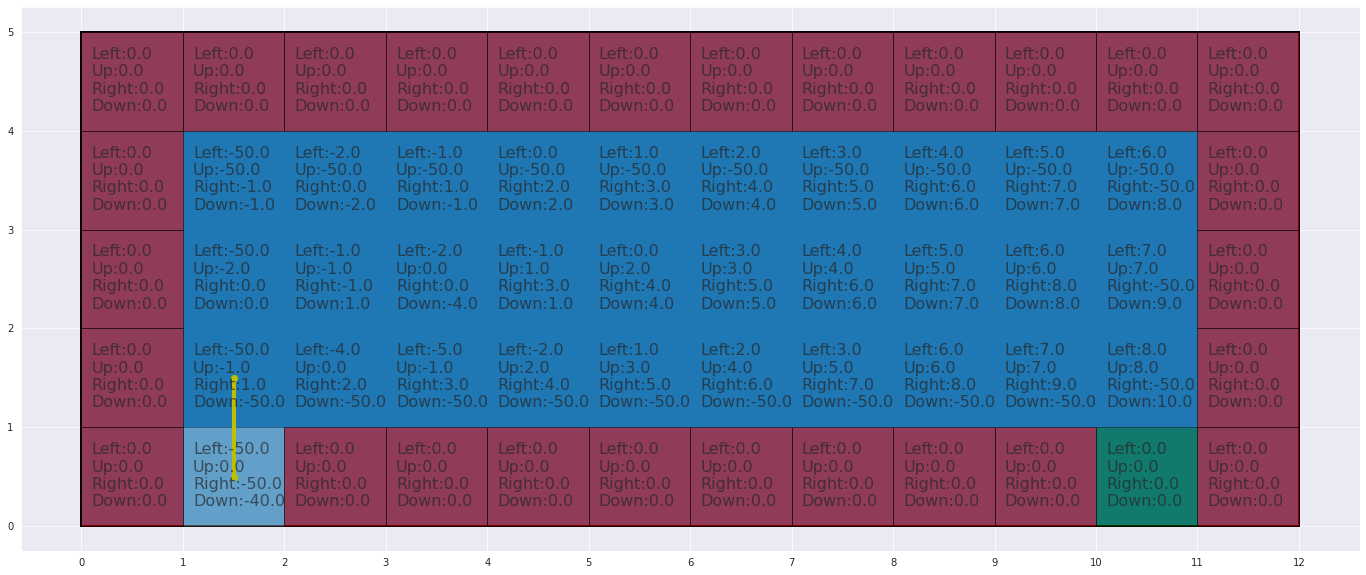

In [ ]:
# Тестируем результат (ставим нулевое значение параметру epsilon):
epsilon = 0
position = train(1)

агент обучился

In [ ]:
points = [-50, -1, 10] #награда

step = ([[-1,0], [0,1], [1,0],[0,-1]])

# Матрица наград игрового поля (Q-таблица): 
rewards = np.zeros((5,13,4)) # 4 - это варианты шага step

start_position = np.array([1,0])

finish_position = np.array([10,0])


# Начальные награды в стартовой точке (инициализируем как -40, чтобы ускорить обучение):
rewards[start_position[1], start_position[0]] = points[0]+10

kf_rewards_list = [0.99, 1, 0.99, 0]
kf_rewards = kf_rewards_list[2]  

epsilon_list = [1, 1, 0, 1]
epsilon = epsilon_list[2]

# Обучаем агента на 200 играх, смотрим, как он обучается:
position1 = train(200)

KeyboardInterrupt: ignored

In [ ]:
# Тестируем результат (ставим нулевое значение параметру epsilon):
epsilon = 0
position = train(1)

про эпсилон = 0 агент завис на 14 игре, не обучался дальше

In [ ]:
points = [-50, -1, 10] #награда

step = ([[-1,0], [0,1], [1,0],[0,-1]])

# Матрица наград игрового поля (Q-таблица): 
rewards = np.zeros((5,13,4)) # 4 - это варианты шага step

start_position = np.array([1,0])

finish_position = np.array([10,0])


# Начальные награды в стартовой точке (инициализируем как -40, чтобы ускорить обучение):
rewards[start_position[1], start_position[0]] = points[0]+10


kf_rewards_list = [0.99, 1, 0.99, 0]
kf_rewards = kf_rewards_list[3]  

epsilon_list = [1, 1, 0, 1]
epsilon = epsilon_list[3]

# Обучаем агента на 200 играх, смотрим, как он обучается:
position3 = train(200)

KeyboardInterrupt: ignored

при kf_rewards = 0, завис на 22 игре, не обучился, что и понятно - награда обнуляется 